# Census Income Project

### Problem Statement:

This data was extracted from the 1994 Census bureau database `https://www.census.gov/en.html` by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

Description of fnlwgt (final weight)

The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

- A single cell estimate of the population 16+ for each state.
- Controls for Hispanic Origin by age and sex.
- Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

In [1]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

Importing all the necessary dependencies/libraries here.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv")

Instead of downloading the entire dataset on my local computer I am simply loading the file directly from the GitHub repository link using the raw option.

In [3]:
df # checking the first 5 and last 5 rows of our dataset

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In the above cell we can see the first 5 and last 5 rows of our dataset. We see that in our dataset there are a total of 32560 rows and 15 columns present. We see a mixture of numerical data columns and text data columns that will need to be converted to numerical format before training our model. Also the problem statement says that we are suppose to predict the "Income" column that has 2 class namely "<=50K" and ">50K" so it makes this as a Classification problem!

# Exploratory Data Analysis (EDA)

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Ensuring that in future observations we do not have any truncated information being displayed in our Jupter Notebook.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Using the `info` method we can see that there are 6 columns with integer data type and 9 columns that have object data type. We will try to spearate these columns for easier analysis purpose.

In [6]:
# getting list of object data type column names
object_datatype = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'object':
        object_datatype.append(x)
print(f"Object Data Type Columns are: ", object_datatype)


# getting the list of float data type column names
integer_datatype = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'int64':
        integer_datatype.append(x)
print(f"\nFloat Data Type Columns are: ", integer_datatype)

Object Data Type Columns are:  ['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country', 'Income']

Float Data Type Columns are:  ['Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss', 'Hours_per_week']


We have successfully bifurcated the object datatype column names and integer data type column names. Since we do not have to worry about outliers and skewness in categorical columns we can use this separated column names to pre process only on numerical continous columns.

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,32560.0,38.581634,13.640642,17.0,28.0,37.0,48.0,90.0
Fnlwgt,32560.0,189781.814373,105549.764924,12285.0,117831.5,178363.0,237054.5,1484705.0
Education_num,32560.0,10.080590,2.572709,1.0,9.0,10.0,12.0,16.0
Capital_gain,32560.0,1077.615172,7385.402999,0.0,0.0,0.0,0.0,99999.0
Capital_loss,32560.0,87.306511,402.966116,0.0,0.0,0.0,0.0,4356.0
Hours_per_week,32560.0,40.437469,12.347618,1.0,40.0,40.0,45.0,99.0


Using the `describe` method we can take a look at the numerical data type columns and observe the distribution of integer data amongst them. The first column shows the count/rows occupied by the columns and since all of them have the same number it indicates that there are no missing values in them. Moving on to other columns I see abnormality in the columns "Capital_gain" and "Capital_loss" that have the value 0.0 for minimum value, 25% data slot, 50% data slot and 75% data slot. However the maximum values are quite huge in number so they might be termed as some kind of outlier but when we speak statistically such kind of data is possible and therefore we will either retain them or treat them accordingly as per our requirement.

In [8]:
df.isna().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

It looks like we do not have any missing data present in our dataset for any of the columns.

<AxesSubplot:>

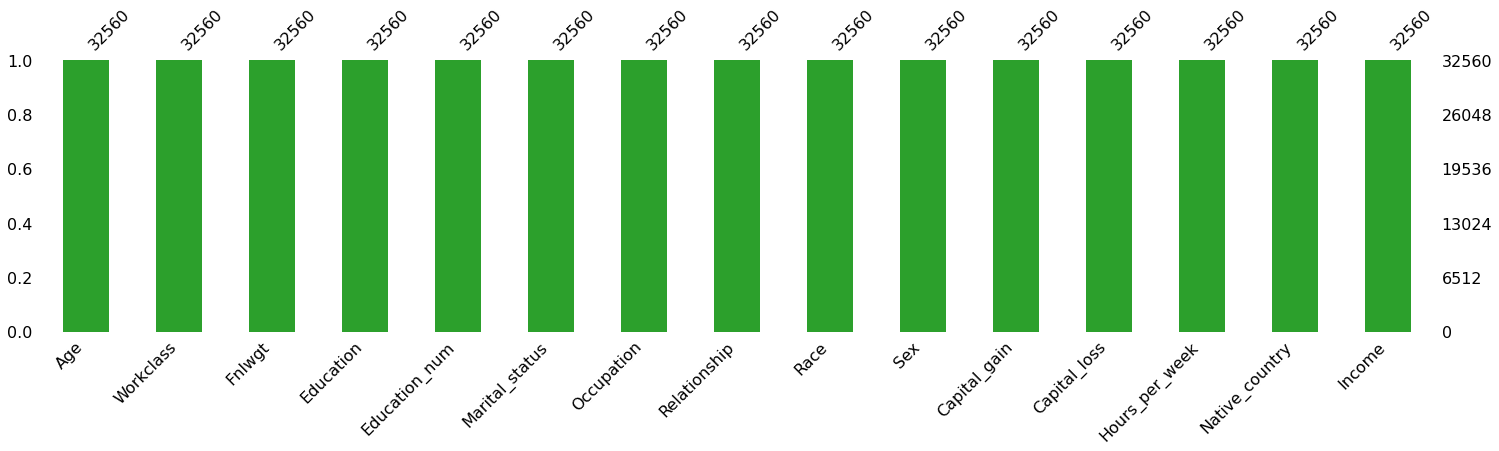

In [9]:
missingno.bar(df, figsize = (25,5), color="tab:green")

We are able to depict the missing values information in a bar plot format where we can clearly see that all the columns have all the rows filled with data and there are no null values present.

In [10]:
print(f"Rows and Columns before dropping duplicates: ", df.shape)
df.drop_duplicates(inplace=True)
print(f"Rows and Columns after dropping duplicates: ", df.shape)

Rows and Columns before dropping duplicates:  (32560, 15)
Rows and Columns after dropping duplicates:  (32536, 15)


With the `drop_duplicates` option I am getting rid of all the duplicate values present in our dataset.

In [11]:
df.nunique().to_frame("Unique Values")

,Unique Values
Age,73
Workclass,9
Fnlwgt,21647
Education,16
Education_num,16
Marital_status,7
Occupation,15
Relationship,6
Race,5
Sex,2


The `nunique` method lists down the number of all the unique data present in each column of our dataset.

In [12]:
for col in object_datatype:
    print(col)
    print(df[col].value_counts())
    print("="*120)

Workclass
 Private             22673
 Self-emp-not-inc     2540
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64
Education
 HS-grad         10494
 Some-college     7282
 Bachelors        5352
 Masters          1722
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           645
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           332
 1st-4th           166
 Preschool          50
Name: Education, dtype: int64
Marital_status
 Married-civ-spouse       14970
 Never-married            10666
 Divorced                  4441
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: Marital_status, dtype: int64
Occupation
 Prof-specialty       41

In the above cell we are taking a look at all the unique values of object data type columns. While eye balling the values we were able to see data that showed "?" in the columns "Workclass", "Occupation" and "Native_country". We will need to replace all the rows that have this "?" in them with a proper name first so that during visualizing and later on encoding these values makes more sense.

In [13]:
df['Workclass'].replace({' ?':' Other-Working-Class'},inplace=True)
df['Occupation'].replace({' ?':' Other-Occupation'},inplace=True)
df['Native_country'].replace({' ?':' Others'},inplace=True)

We have successfully replaced all the "?" data present in the columns "Workclass", "Occupation" and "Native_country" with meaningful values.

# Visualization

In [14]:
print(f"Object Data Type Column Names: ", object_datatype)
print(f"\nInteger Data Type Column Names: ", integer_datatype)

Object Data Type Column Names:  ['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country', 'Income']

Integer Data Type Column Names:  ['Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss', 'Hours_per_week']


Lisiting out the column names for object datatype and integer datatype respectively.

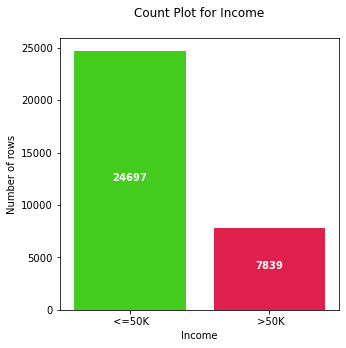

In [15]:
try:
    plt.figure(figsize=(5,5))
    col_name = 'Income'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above count plot we can see that our target label "Income" column has imbalaned dataset that will need to be taken care of before we start building our classification machine learning model.

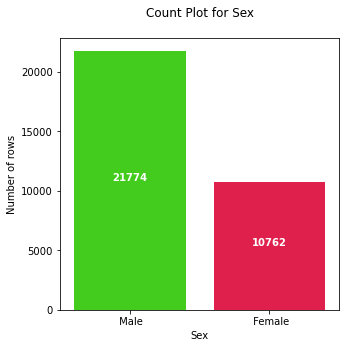

In [16]:
try:
    plt.figure(figsize=(5,5))
    col_name = 'Sex'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above count plot we can see that the number of data values for male is higher than that of it's female counterparts.

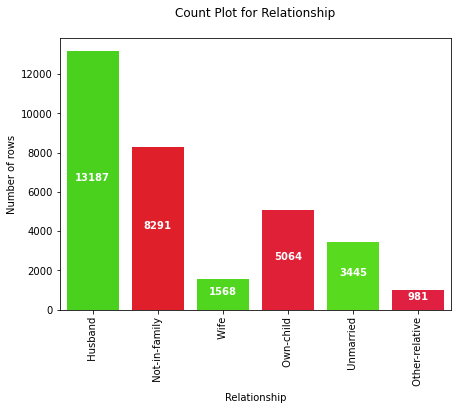

In [17]:
try:
    plt.figure(figsize=(7,5))
    col_name = 'Relationship'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above count plot we see that in the "Relationship" status the values for husband is the highest and other relative has the lowest data.

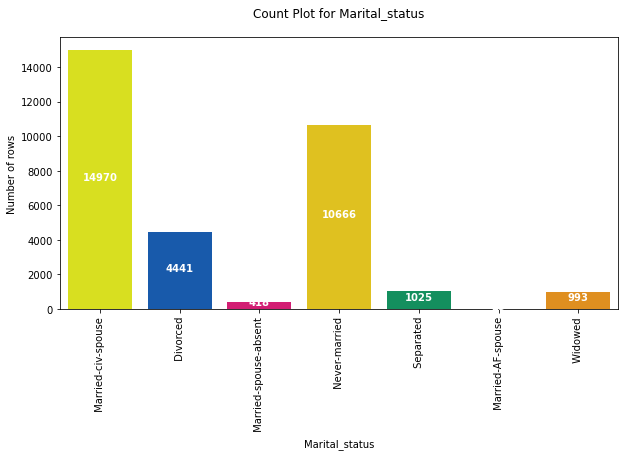

In [18]:
try:
    plt.figure(figsize=(10,5))
    col_name = 'Marital_status'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above countplot we see that the Marital Status column has married spouse and never married people on the higher edge as compared to the other values.

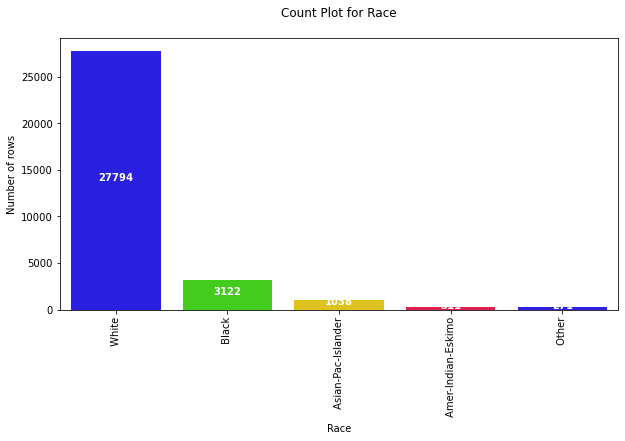

In [19]:
try:
    plt.figure(figsize=(10,5))
    col_name = 'Race'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above countplot we see that the Race column mostly comprises of White people in the dataset.

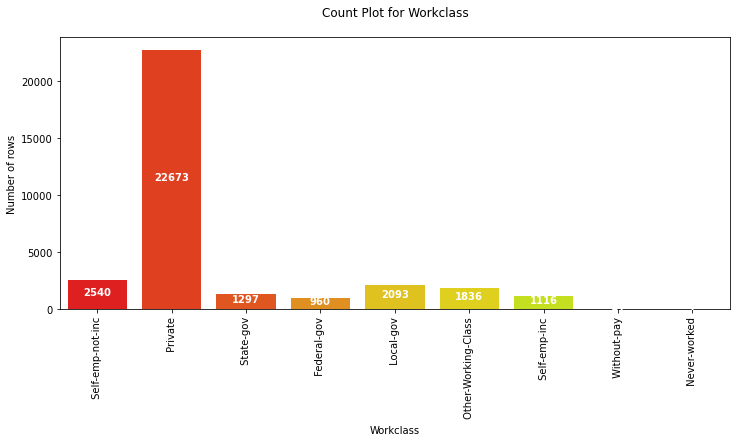

In [20]:
try:
    plt.figure(figsize=(12,5))
    col_name = 'Workclass'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above countplot we see that in the Work Class column the highest number of people work for private sector and the other work classes or people who are unemployed is quite less to negligible.

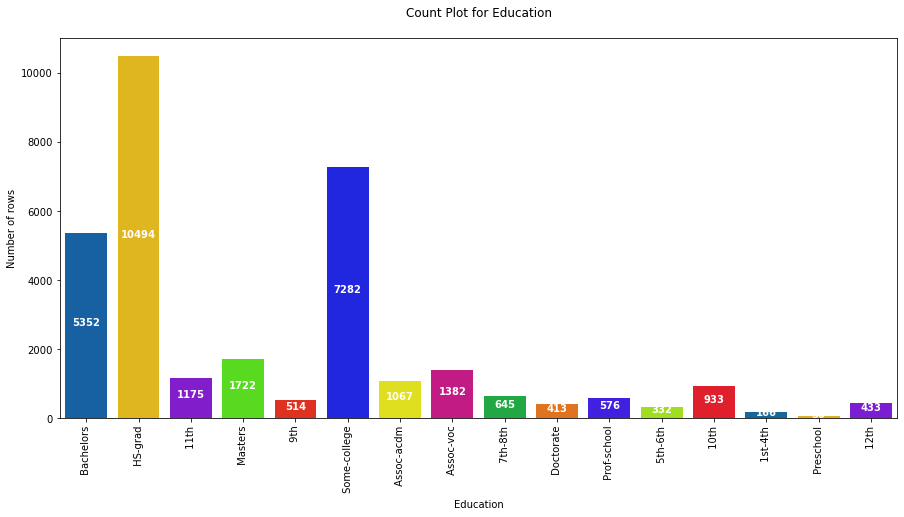

In [21]:
try:
    plt.figure(figsize=(15,7))
    col_name = 'Education'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above countplot we see that the Education column has the highest number of values in HS grad followed by Some college and Bachelors. Remaining education categories have quite lesser data coverage in our dataset.

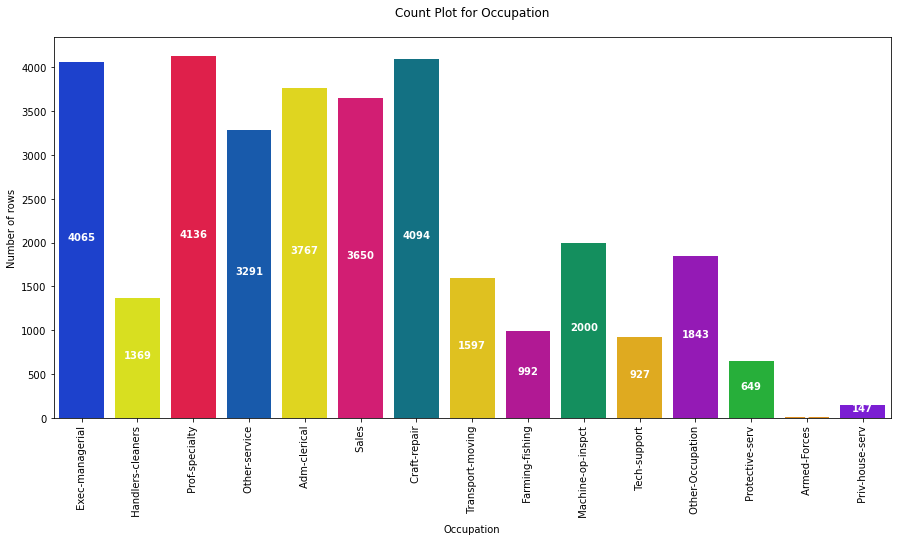

In [22]:
try:
    plt.figure(figsize=(15,7))
    col_name = 'Occupation'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above countplot we can see that the Occupation column has various categories out of which people in Armed Forces are the least and folks engaged in some craft repair, executive managers and holding some professional speciality are on the rise.

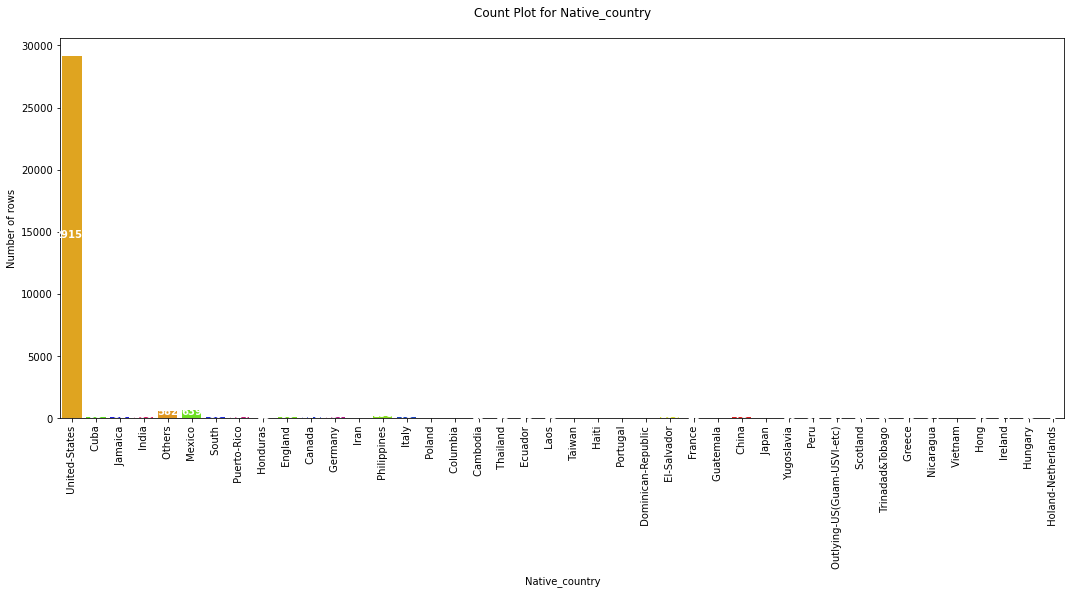

In [23]:
try:
    plt.figure(figsize=(18,7))
    col_name = 'Native_country'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above countplot we can clearly see that the Native Country column has the highest value for US followed by Mexico and Others while the remaining categories has the least to neligible amount of data coverage.

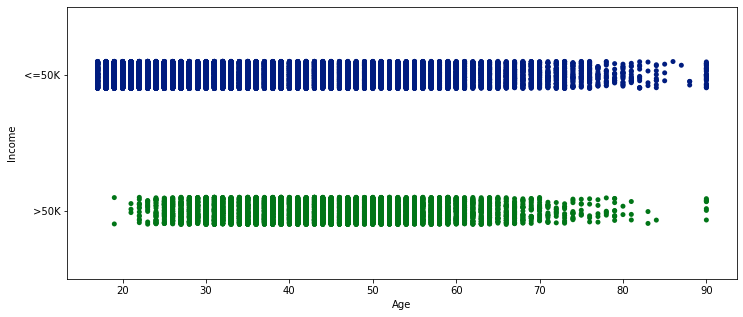

In [24]:
plt.style.use('seaborn-dark-palette')
plt.figure(figsize=(12,5))
sns.stripplot(x = 'Age', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that young people hardly have income more than 50K.

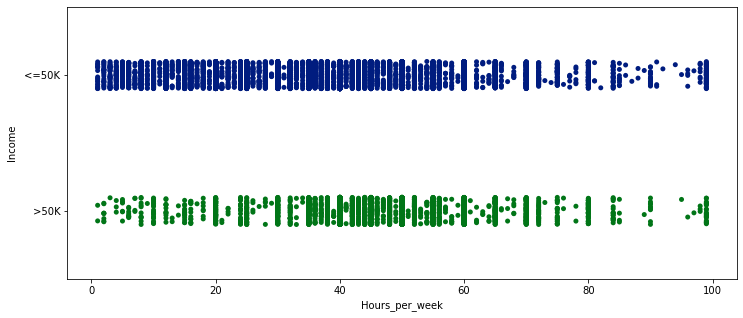

In [25]:
plt.figure(figsize=(12,5))
sns.stripplot(x = 'Hours_per_week', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that people who have income less than or equal to 50K put in more hours per week as compared to the one's who earn more than 50K as income.

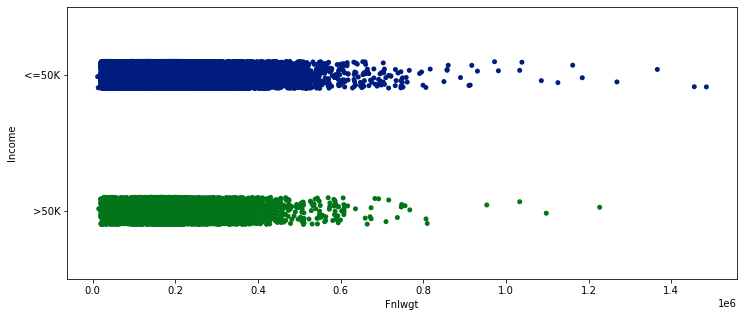

In [26]:
plt.figure(figsize=(12,5))
sns.stripplot(x = 'Fnlwgt', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that the final weight has data coverage on a higher scale for people in the <=50K income bracket as compared to the people in >50K income bracket.

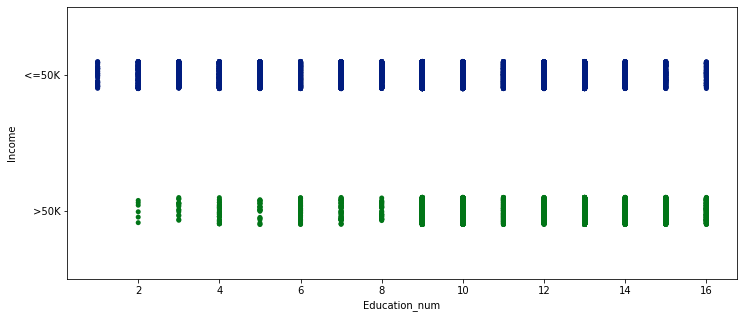

In [27]:
plt.figure(figsize=(12,5))
sns.stripplot(x = 'Education_num', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that the lower education number is almost negligibe for people with income >50K and it therefore emphasizes on the importance of education too.

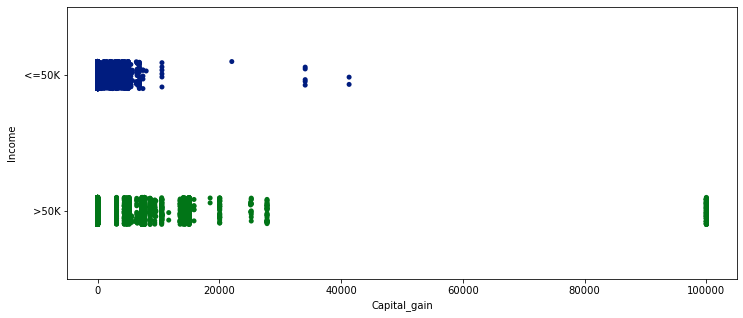

In [28]:
plt.figure(figsize=(12,5))
sns.stripplot(x = 'Capital_gain', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that the capital gain is on a higher scale for people with income >50K

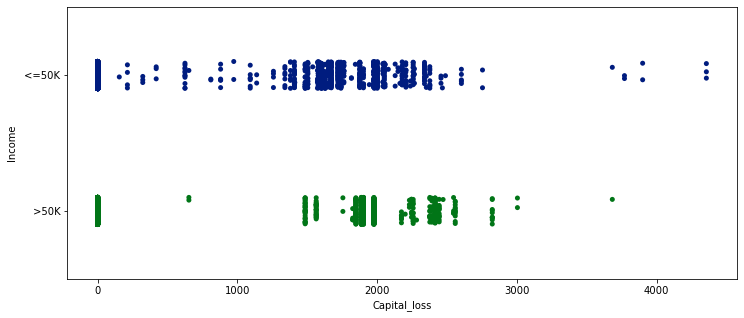

In [29]:
plt.figure(figsize=(12,5))
sns.stripplot(x = 'Capital_loss', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that the capital loss for people with income >50K is considerably less than people with income <=50K

Text(0, 0.5, 'Percentage of People')

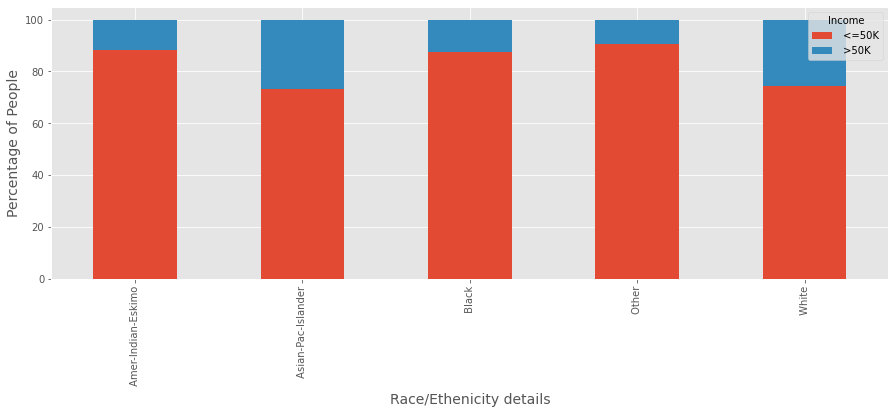

In [30]:
plt.style.use('ggplot')
tbl = pd.crosstab(df['Race'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Race/Ethenicity details', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us different ethenicity race group folks and the income variations between them.

Text(0, 0.5, 'Percentage of People')

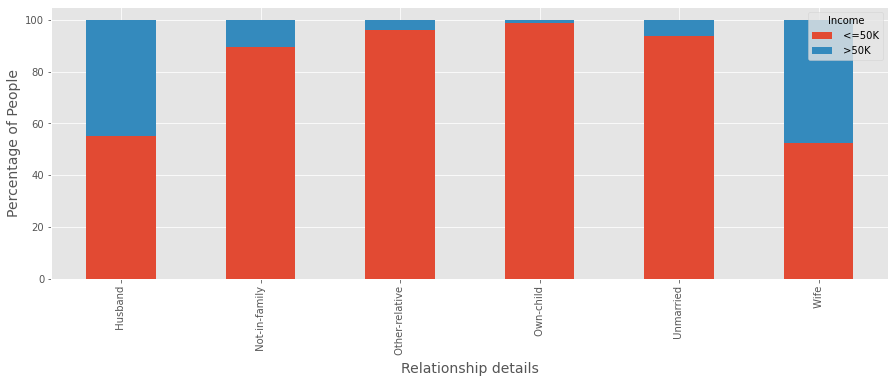

In [31]:
tbl = pd.crosstab(df['Relationship'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Relationship details', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us the difference in income details for people in different relationship status. People who are earning >50K are mostly from the relationship status husband or wife.

Text(0, 0.5, 'Percentage of People')

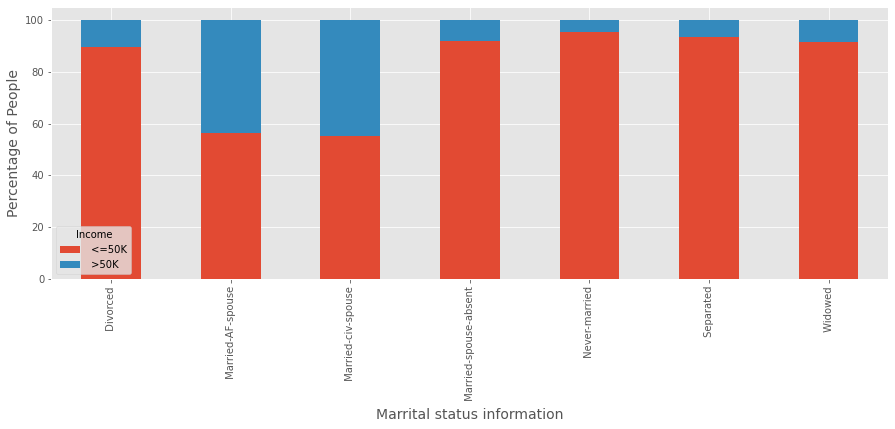

In [32]:
tbl = pd.crosstab(df['Marital_status'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Marrital status information', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us the marrital status of people who have income either <=50K or >50K.

Text(0, 0.5, 'Percentage of People')

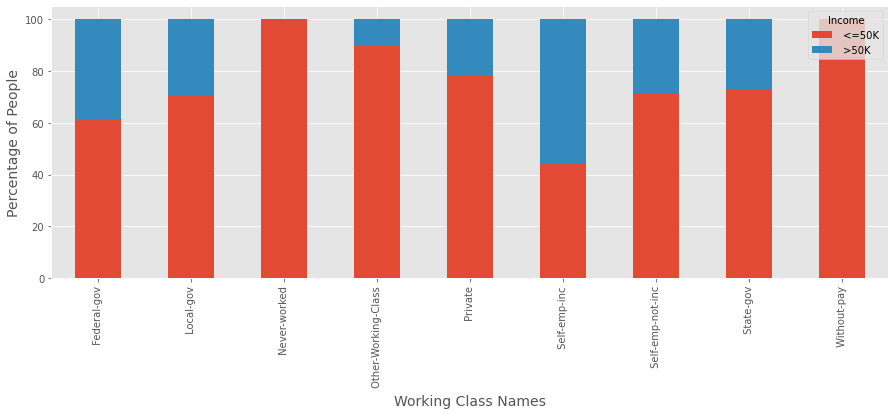

In [33]:
tbl = pd.crosstab(df['Workclass'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Working Class Names', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us the working class information and people who have never worked or are sitting without pay obviously come under <=50K income bracket while mostly people who are self employed or own a business are able to make an income of >50K.

Text(0, 0.5, 'Percentage of People')

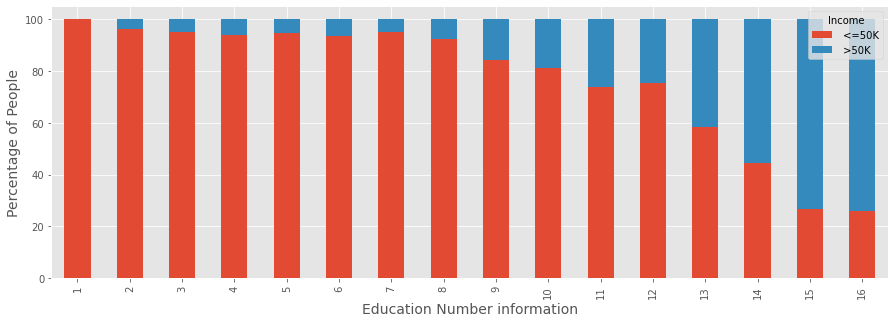

In [34]:
tbl = pd.crosstab(df['Education_num'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Education Number information', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us the education number scale which indicated that to earn an income of >50K you need to have a higher educational number emphasizing the importance on the educational front.

Text(0, 0.5, 'Percentage of People')

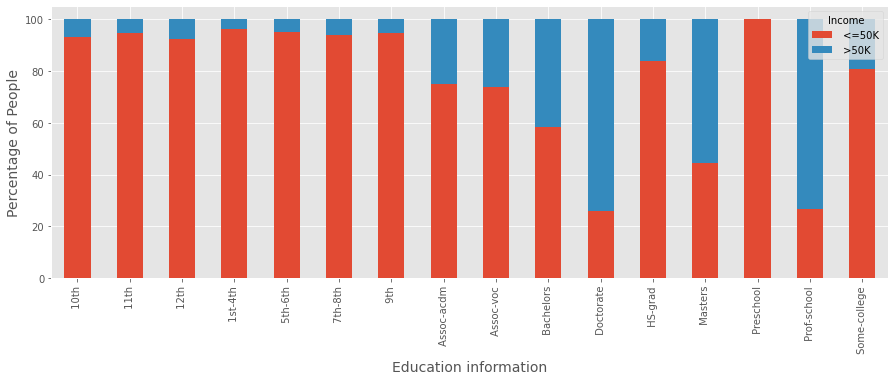

In [35]:
tbl = pd.crosstab(df['Education'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Education information', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us the different education types for people and their income scale. It looks like people with >50K income have a qualification in doctorate, masters and professional school.

Text(0, 0.5, 'Percentage of People')

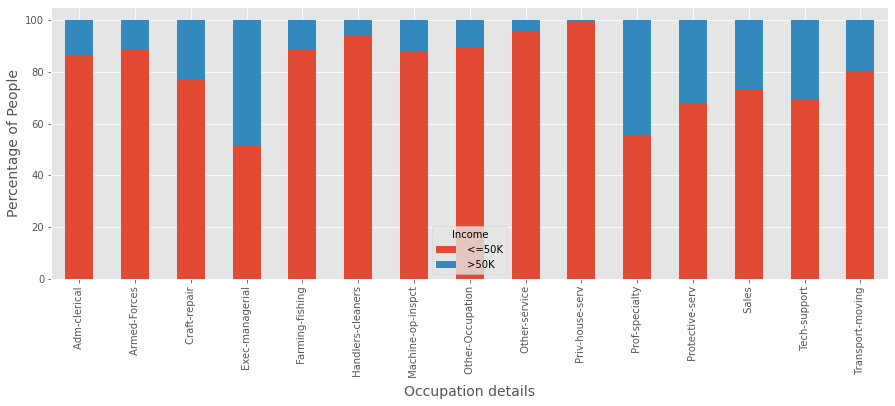

In [36]:
tbl = pd.crosstab(df['Occupation'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Occupation details', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us all the occupation information for people and to earn an income of >50K the designations which help are executive managerial position, professional speciality position, protective services, technical support position and sales positions.

Text(0, 0.5, 'Percentage of People')

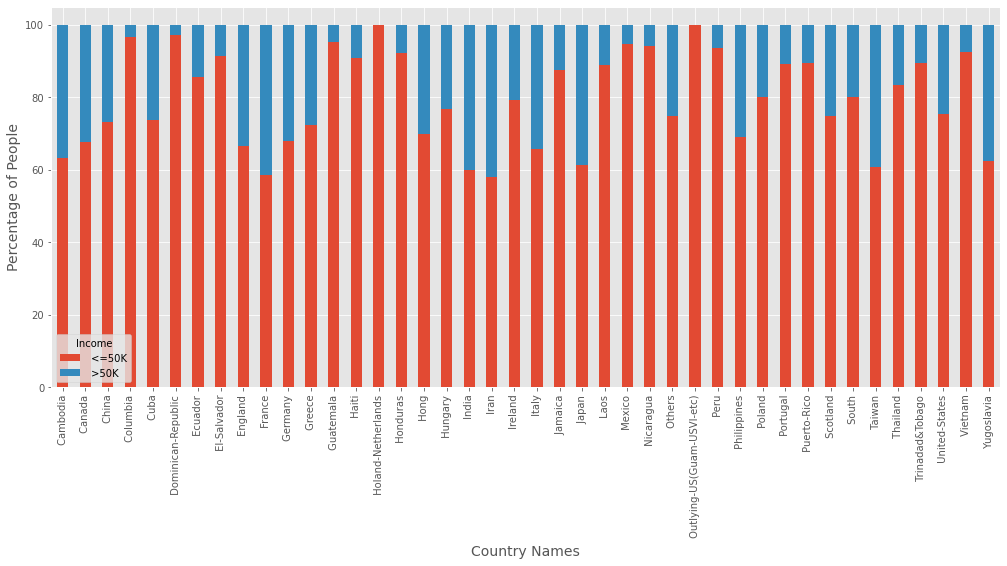

In [37]:
tbl = pd.crosstab(df['Native_country'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).sort_values(col_name).plot(kind='bar',stacked=True,figsize=(17,7))
plt.xlabel('Country Names', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us the native country details for people settled in the US. In order to earn >50K the native country details recorded are for Cambodia, Canada, France, Germany, Greece, Hong Kong, India, Iran, Italy, Japan, Phillipines, Taiwan, Yugoslavia.

Text(0, 0.5, 'Percentage of People')

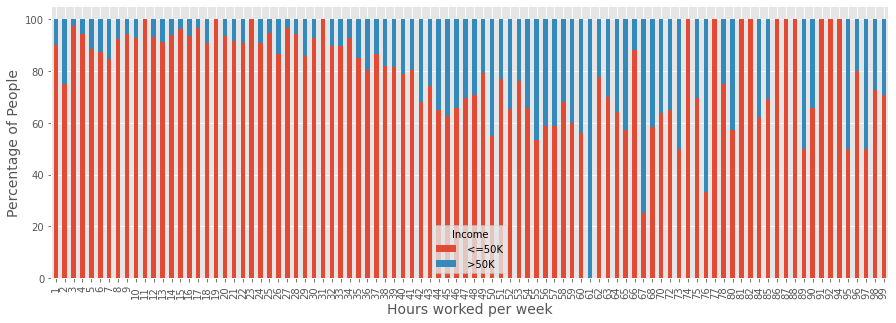

In [38]:
tbl = pd.crosstab(df['Hours_per_week'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Hours worked per week', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us that people with >50K income mostly work 61 hours per week or range from 50-80 hours per week mostly.

Text(0, 0.5, 'Percentage of People')

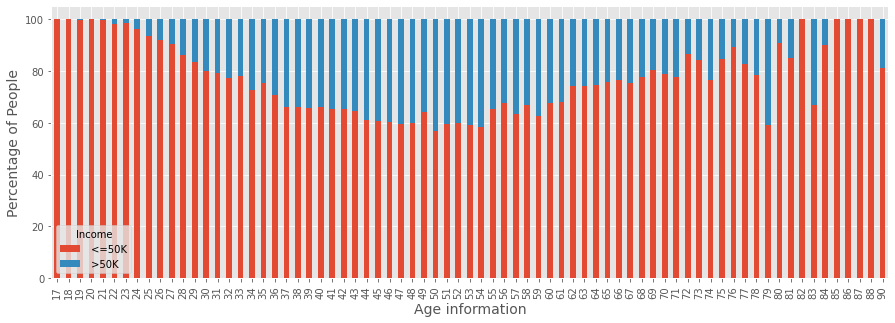

In [39]:
tbl = pd.crosstab(df['Age'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Age information', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us that younger people mostly have an income of <=50K and older people generally have an income of >50K.

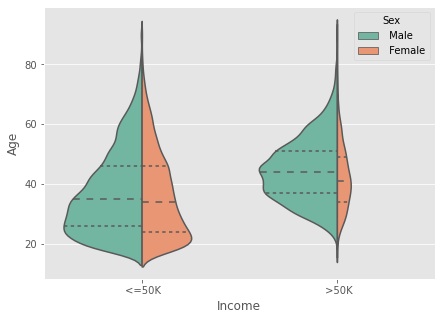

In [40]:
plt.figure(figsize=(7,5))
sns.violinplot(x="Income", y="Age", hue="Sex", data=df, 
               palette="Set2", split=True, scale="count", inner="quartile")
plt.show()

Above violin plot shows us that male in any age group and income group have a higher number than their female counterparts.

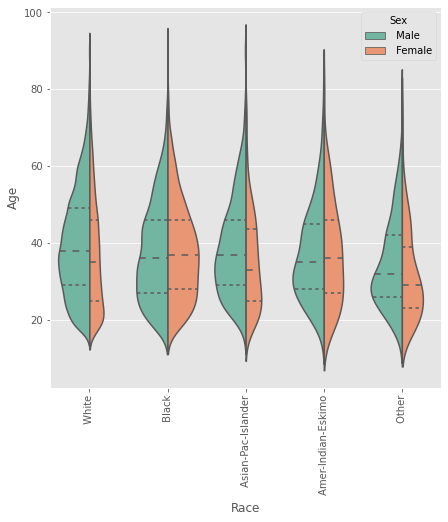

In [41]:
plt.figure(figsize=(7,7))
sns.violinplot(x="Race", y="Age", hue="Sex", data=df, 
               palette="Set2", split=True, scale="count", inner="quartile")
plt.xticks(rotation=90)
plt.show()

Above violin plot shows us that female with black ethinicity of any age group is higher than the other ethinicity group females.

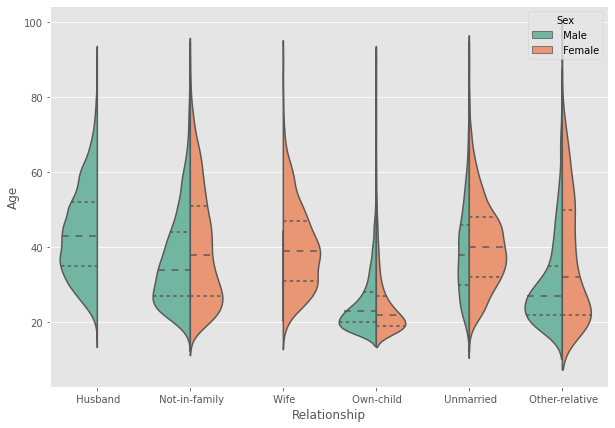

In [42]:
plt.figure(figsize=(10,7))
sns.violinplot(x="Relationship", y="Age", hue="Sex", data=df, 
               palette="Set2", split=True, scale="count", inner="quartile")
plt.show()

Above violin plot shows us that people in the own child relationship age from 10-40. Also we have female who are unmarried more than the male counter parts.

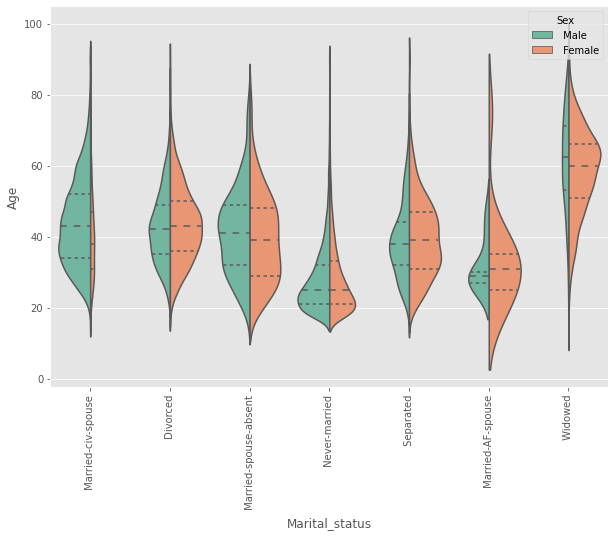

In [43]:
plt.figure(figsize=(10,7))
sns.violinplot(x="Marital_status", y="Age", hue="Sex", data=df, 
               palette="Set2", split=True, scale="count", inner="quartile")
plt.xticks(rotation=90)
plt.show()

Above violin plot shows us that the marital status as married spouse have a higher number in male than in female and people who are widowed have a higher number in females as compared to the males.

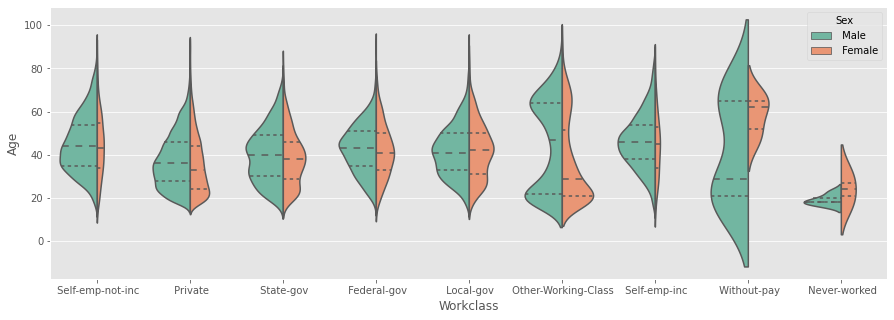

In [44]:
plt.figure(figsize=(15,5))
sns.violinplot(x="Workclass", y="Age", hue="Sex", data=df, 
               palette="Set2", split=True, scale="count", inner="quartile")
plt.show()

Above violin plot shows us that male cover most of the working class sectors in each category as compared to the females.

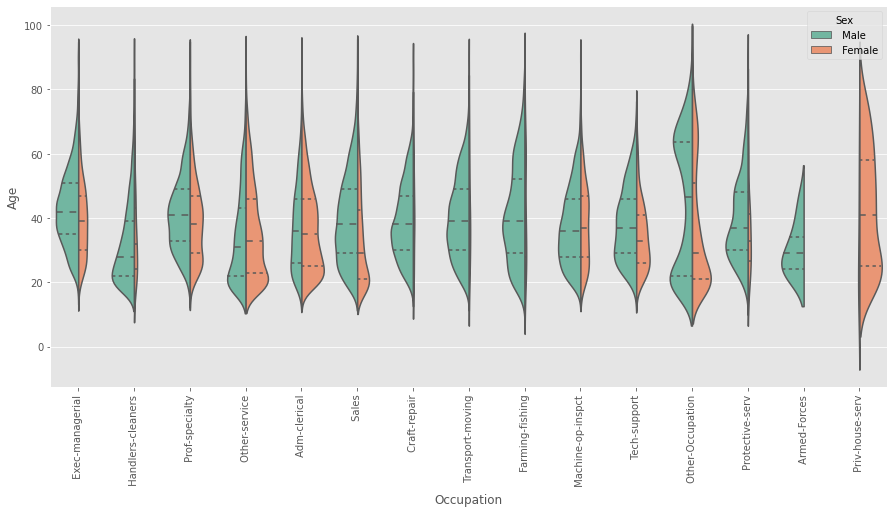

In [45]:
plt.figure(figsize=(15,7))
sns.violinplot(x="Occupation", y="Age", hue="Sex", data=df, 
               palette="Set2", split=True, scale="count", inner="quartile")
plt.xticks(rotation=90)
plt.show()

Above violin plot shows us that the designation of private house services has more number of female mostly from the 20-60 age group while occupations such as craft repair, transport moving, farming/fishing, protective/security service and armed forces have a larger number of data coverage for males.

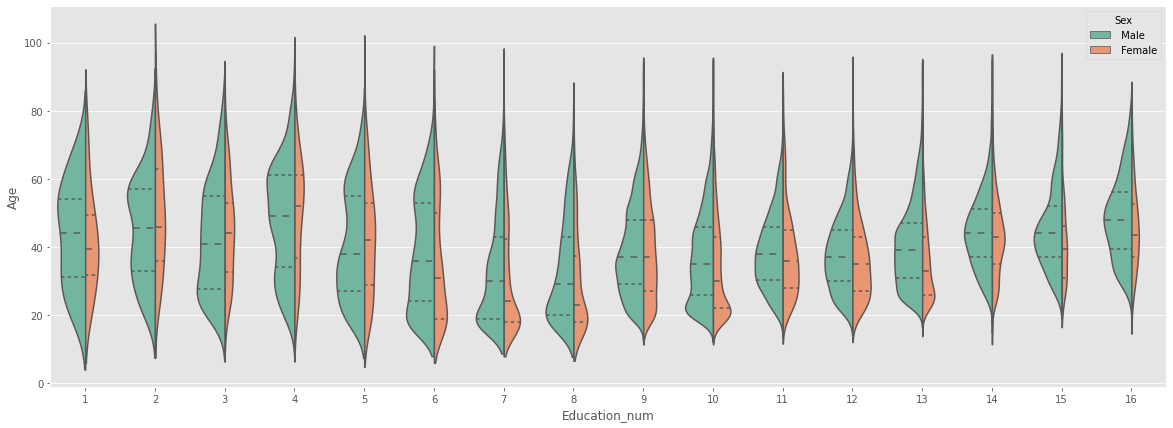

In [46]:
plt.figure(figsize=(20,7))
sns.violinplot(x="Education_num", y="Age", hue="Sex", data=df, 
               palette="Set2", split=True, scale="count", inner="quartile")
plt.show()

Above violin plot shows us that males in all age group have a higher education number compared to their female counter parts.

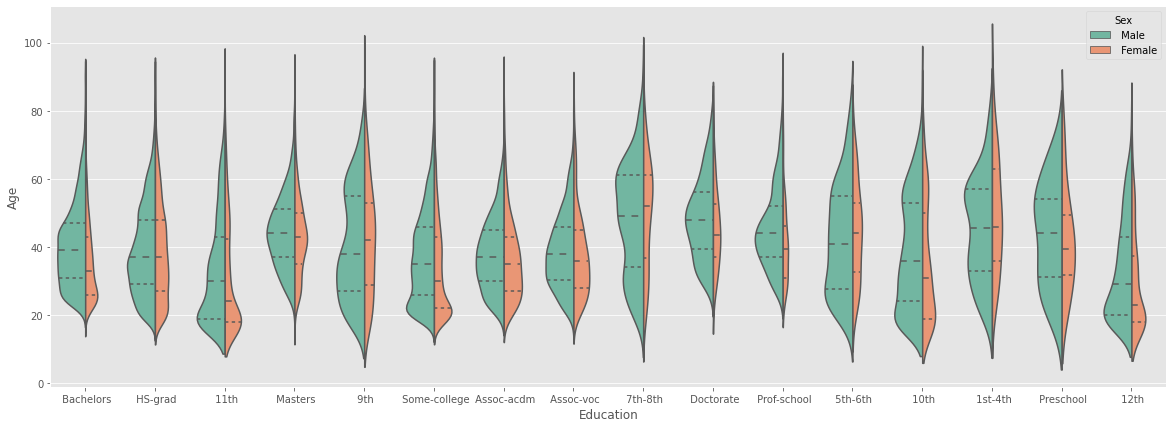

In [47]:
plt.figure(figsize=(20,7))
sns.violinplot(x="Education", y="Age", hue="Sex", data=df, 
               palette="Set2", split=True, scale="count", inner="quartile")
plt.show()

Above violin plot shows us that just like the education number the education category sees more number of males than their female counter parts giving us a red flag on how female education is a concern.

# Encoding the categorical object datatype columns

In [48]:
# Label Encoder

le = LabelEncoder()
df["Income"] = le.fit_transform(df["Income"])
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0


I have used `LabelEncoder` to convert the object data type in our label column "Income" to a numerical format.

In [49]:
# Ordinal Encoder

oe = OrdinalEncoder()
df['Workclass'] = oe.fit_transform(df['Workclass'].values.reshape(-1,1))
df['Education'] = oe.fit_transform(df['Education'].values.reshape(-1,1))
df['Marital_status'] = oe.fit_transform(df['Marital_status'].values.reshape(-1,1))
df['Occupation'] = oe.fit_transform(df['Occupation'].values.reshape(-1,1))
df['Relationship'] = oe.fit_transform(df['Relationship'].values.reshape(-1,1))
df['Native_country'] = oe.fit_transform(df['Native_country'].values.reshape(-1,1))
df['Race'] = oe.fit_transform(df['Race'].values.reshape(-1,1))
df['Sex'] = oe.fit_transform(df['Sex'].values.reshape(-1,1))
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,6.0,83311,9.0,13,2.0,3.0,0.0,4.0,1.0,0,0,13,39.0,0
1,38,4.0,215646,11.0,9,0.0,5.0,1.0,4.0,1.0,0,0,40,39.0,0
2,53,4.0,234721,1.0,7,2.0,5.0,0.0,2.0,1.0,0,0,40,39.0,0
3,28,4.0,338409,9.0,13,2.0,10.0,5.0,2.0,0.0,0,0,40,4.0,0
4,37,4.0,284582,12.0,14,2.0,3.0,5.0,4.0,0.0,0,0,40,39.0,0


I could have used one hot encoder here but I preferred to use `OrdinalEncoder` to ensure that the number of columns do not get increased unnecessarily.

In [80]:
print(f"Shape of our data frame post encoding is", df.shape)
df.isnull().sum()

Shape of our data frame post encoding is (27763, 15)


Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

I am checking the number of rows and columns present in our dataset after applying the enconding techniques and ensuring that there are no null values present in them.

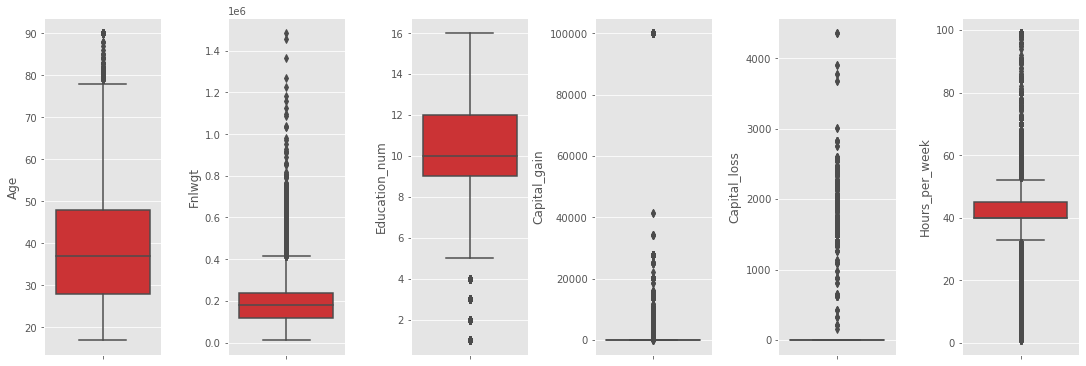

In [51]:
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df[integer_datatype].items():
    sns.boxplot(y=col, data=df, ax=ax[index], palette="Set1")
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

With the help of box plot we can see the outlier details present in our numerical data columns which will need to be treated.

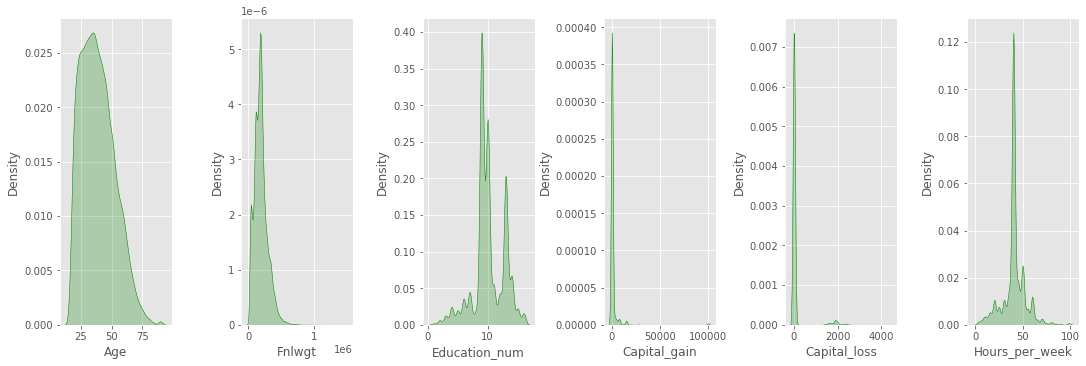

In [52]:
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df[integer_datatype].items():
    sns.distplot(value, ax=ax[index], hist=False, color="g", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

With the help of distribution plot we can see the skewness details present in our numerical data columns which will need to be treated.

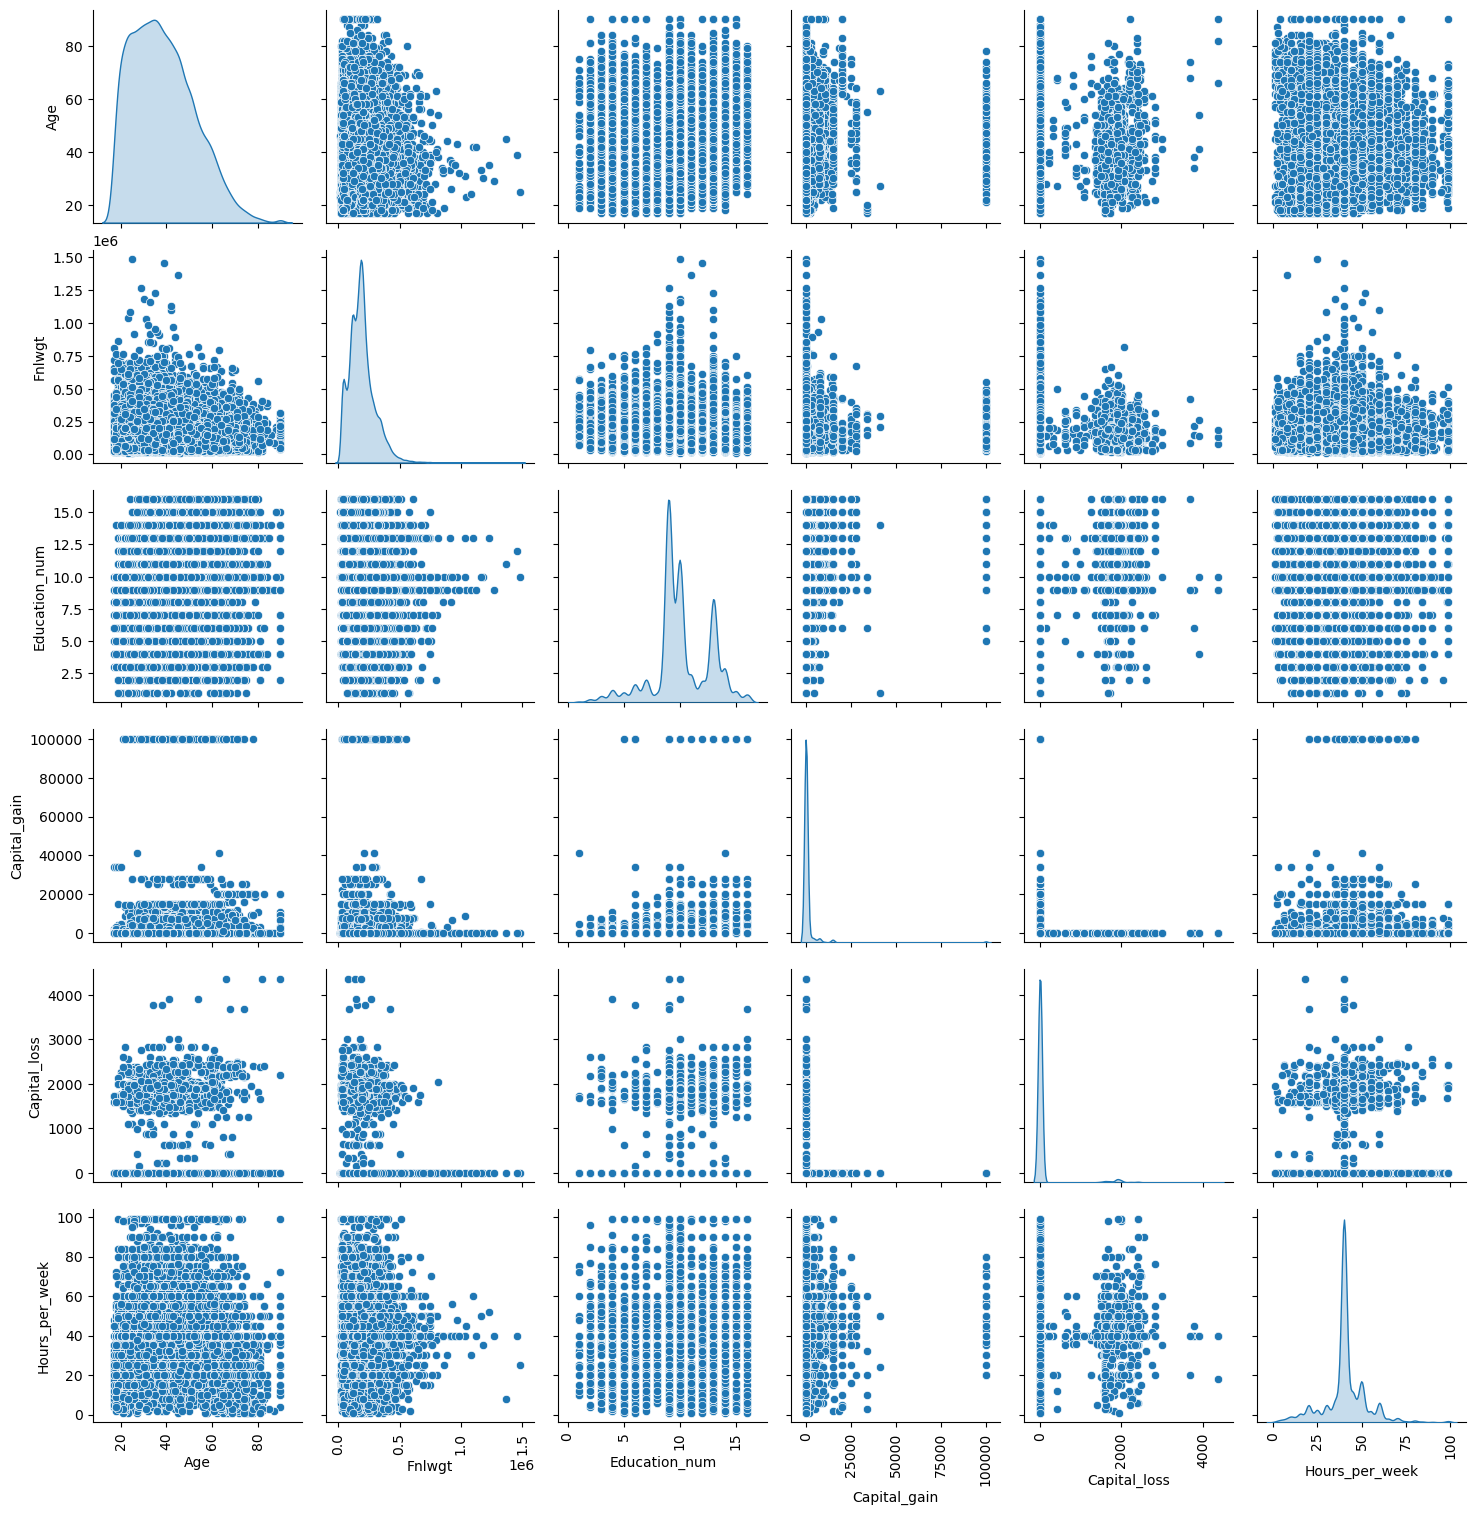

In [53]:
num_values = df.drop(['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
                      'Native_country', 'Income'], axis=1)
plt.style.use('default')
g = sns.pairplot(num_values, diag_kind="kde")
for ax in g.axes.flat:
    ax.tick_params("x", labelrotation=90)
plt.show()

I have generated the above pairplot for our continous data columns and show us how the data points are available in each of them.

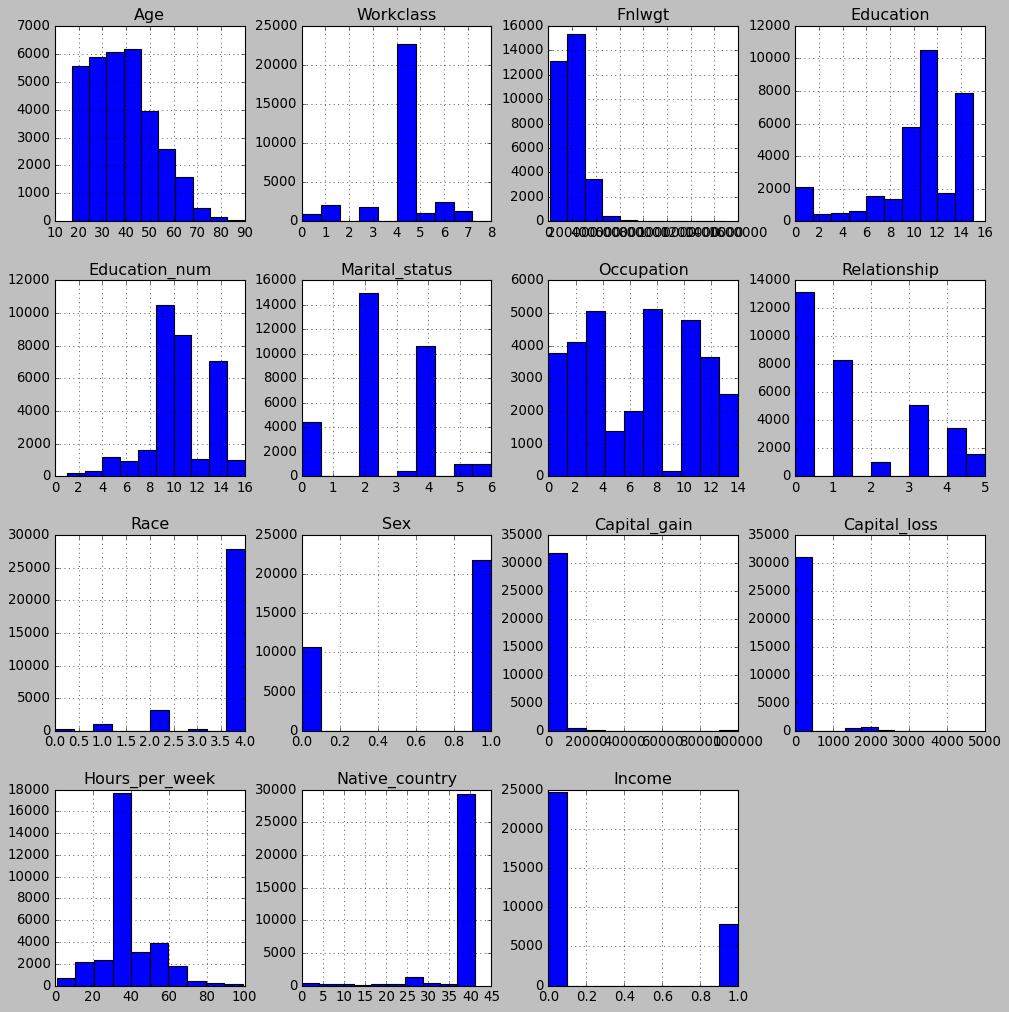

In [54]:
plt.style.use('classic')
df.hist(figsize=(15,15))
plt.show()

I have generated a histogram for all our dataset columns after applying enconding and converting object datatype to numeric datatype values.

# Correlation using a Heatmap

- Positive correlation - A correlation of +1 indicates a perfect positive correlation, meaning that both variables move in the same direction together.
- Negative correlation - A correlation of –1 indicates a perfect negative correlation, meaning that as one variable goes up, the other goes down.

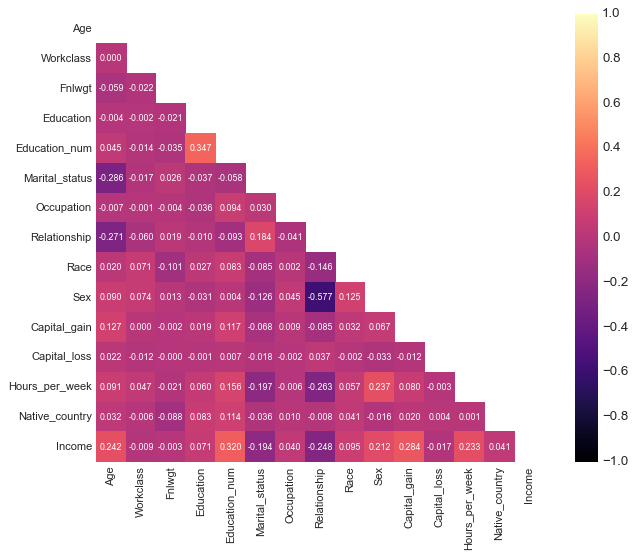

In [81]:
plt.style.use('seaborn-pastel')
upper_triangle = np.triu(df.corr())
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.3f', 
            annot_kws={'size':8}, cmap="magma", mask=upper_triangle)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In the above heatmap we can see the correlation details plus we can determine that there is no multi colinearity issue between our columns.

# Correlation Bar Plot comparing features with our label

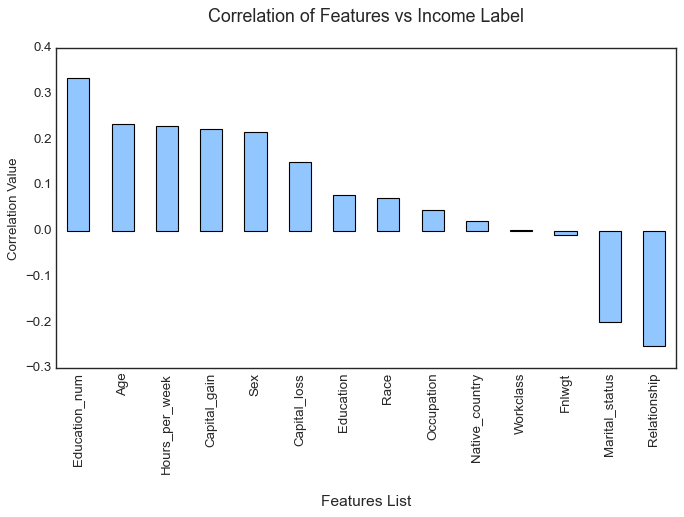

In [56]:
plt.style.use('seaborn-white')
df_corr = df.corr()
plt.figure(figsize=(10,5))
df_corr['Income'].sort_values(ascending=False).drop('Income').plot.bar()
plt.title("Correlation of Features vs Income Label\n", fontsize=16)
plt.xlabel("\nFeatures List", fontsize=14)
plt.ylabel("Correlation Value", fontsize=12)
plt.show()

Since the heatmap was not able to give us a clear picture on positive and negative correlation columns we have generated this bar plot and we see that columns relationship and marital status are the only one's negatively correlated rest all the other feature columns are positively correlated with our label column.

# Using Z Score to remove outliers

In [57]:
z = np.abs(zscore(df))
threshold = 3
df1 = df[(z<3).all(axis = 1)]

print ("Shape of the dataframe before removing outliers: ", df.shape)
print ("Shape of the dataframe after removing outliers: ", df1.shape)
print ("Percentage of data loss post outlier removal: ", (df.shape[0]-df1.shape[0])/df.shape[0]*100)

df=df1.copy() # reassigning the changed dataframe name to our original dataframe name

Shape of the dataframe before removing outliers:  (32536, 15)
Shape of the dataframe after removing outliers:  (27763, 15)
Percentage of data loss post outlier removal:  14.669904106220802


I have used the Z score method to remove the outliers and even though we are losing 14.669904106220802 % of data I am able to afford that loss considering we have a lot of rows in our datatset to be used while model building.

In [58]:
df.skew()

Age                0.484855
Workclass         -0.663507
Fnlwgt             0.629184
Education         -0.955853
Education_num     -0.145432
Marital_status    -0.045123
Occupation         0.101481
Relationship       0.753529
Race              -2.585947
Sex               -0.689396
Capital_gain       4.929937
Capital_loss      29.510814
Hours_per_week    -0.358912
Native_country    -4.368853
Income             1.321803
dtype: float64

With the `skew` method we see that there are columns present in our dataset that are above the acceptable range of +/-0.5 value.

# Using Log Transform to fix skewness

In [59]:
for col in integer_datatype:
    if df.skew().loc[col]>0.55:
        df[col]=np.log1p(df[col])

I have applied `Log Transformation` on our numerical integer datatype columns to ensure that we do not have skewness in our dataset.

In [60]:
df.skew()

Age                0.484855
Workclass         -0.663507
Fnlwgt            -0.955984
Education         -0.955853
Education_num     -0.145432
Marital_status    -0.045123
Occupation         0.101481
Relationship       0.753529
Race              -2.585947
Sex               -0.689396
Capital_gain       3.111123
Capital_loss      25.003969
Hours_per_week    -0.358912
Native_country    -4.368853
Income             1.321803
dtype: float64

We have managed to reduce the skewness from our numerical columns and that can be seen above while we have ignored the skewness and outlier details for our categorical data.

# Splitting the dataset into 2 variables namely 'X' and 'Y' for feature and label

In [61]:
X = df.drop('Income', axis=1)
Y = df['Income']

I have bifurcated the dataset into features and labels where X represents all the feature columns and Y represents the target label column.

# Resolving the class imbalance issue in our label column

In [62]:
Y.value_counts()

0    21535
1     6228
Name: Income, dtype: int64

Listing the values of our label column to count the number of rows occupied by each category. This indicates class imbalance that we will need to fix by using the oversampling method.

In [63]:
# adding samples to make all the categorical label values same

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

`SMOTE` is the over sampling mechanism that we are using to ensure that all the categories present in our target label have the same value.

In [64]:
Y.value_counts()

0    21535
1    21535
Name: Income, dtype: int64

After applying over sampling we are once again listing the values of our label column to cross verify the updated information. Here we see that we have successfully resolved the class imbalance problem and now all the categories have same data ensuring that the machine learning model does not get biased towards one category.

# Feature Scaling

In [65]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country
0,0.776210,1.544837,-1.141057,-0.433588,1.014928,-0.318645,-0.815304,-0.730460,0.308203,0.607266,-0.381964,-0.033411,-2.643204,0.211603
1,-0.172552,0.052865,0.525250,0.136120,-0.635365,-1.853709,-0.357819,-0.107410,0.308203,0.607266,-0.381964,-0.033411,-0.152090,0.211603
2,1.013401,0.052865,0.673754,-2.712419,-1.460511,-0.318645,-0.357819,-0.730460,-3.496539,0.607266,-0.381964,-0.033411,-0.152090,0.211603
3,-0.251615,0.052865,1.011243,0.420974,1.427501,-0.318645,-0.815304,2.384793,0.308203,-1.695259,-0.381964,-0.033411,-0.152090,0.211603
4,0.697147,0.052865,0.004369,-1.288150,-2.285657,0.448886,0.328407,-0.107410,-3.496539,-1.695259,-0.381964,-0.033411,-2.366414,-5.853937


I am scaling my feature data to ensure that there is no issue with the data biasness over a particular column instead a standardization will occur helping us in having a uniform dataset value.

# Finding best random state for building Classification Models

In [66]:
maxAccu=0
maxRS=0

for i in range(1, 1000):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=i)
    lr=LogisticRegression()
    lr.fit(X_train, Y_train)
    pred = lr.predict(X_test)
    acc_score = (accuracy_score(Y_test, pred))*100
    
    if acc_score>maxAccu:
        maxAccu=acc_score
        maxRS=i

print("Best accuracy score is", maxAccu,"on Random State", maxRS)

Best accuracy score is 77.90676077265974 on Random State 725


Great so with the help of random state selection process we have found our lucky number to be "725" amongst 1-1000 range.

# Feature importance bar graph

,Importance
Features,
Marital_status,0.166
Relationship,0.144
Age,0.137
Fnlwgt,0.121
Education_num,0.073
Occupation,0.071
Hours_per_week,0.064
Capital_gain,0.063
Education,0.052


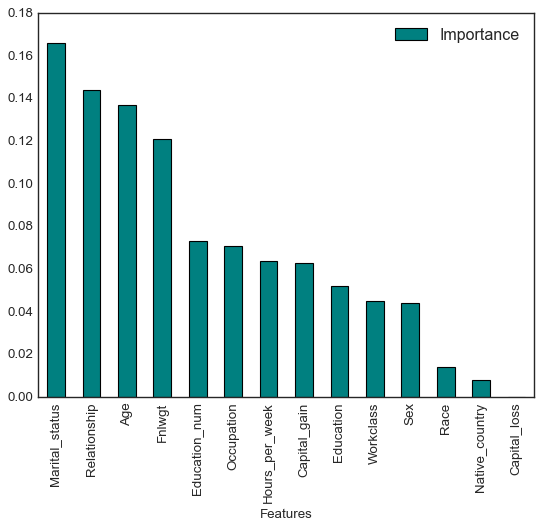

In [67]:
rf=RandomForestClassifier()
rf.fit(X_train, Y_train)
importances = pd.DataFrame({'Features':X.columns, 'Importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Features')
importances.plot.bar(color='teal')
importances

Here with the help of `RandomForestClassifier` we are able to list down the importance or priority given to a column as per it's involvement or weightage in predicting our label.

# Machine Learning Model for Classification with Evaluation Metrics

In [68]:
# Classification Model Function

def classify(model, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=725)
    
    # Training the model
    model.fit(X_train, Y_train)
    
    # Predicting Y_test
    pred = model.predict(X_test)
    
    # Classification Report
    class_report = classification_report(Y_test, pred)
    print("\nClassification Report:\n", class_report)
    
    # Accuracy Score
    acc_score = (accuracy_score(Y_test, pred))*100
    print("Accuracy Score:", acc_score)
    
    # Cross Validation Score
    cv_score = (cross_val_score(model, X, Y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    
    # Result of accuracy minus cv scores
    result = acc_score - cv_score
    print("\nAccuracy Score - Cross Validation Score is", result)

I have defined a class that will perform the train-test split, training of machine learning model, predicting the label value, getting the accuracy score, generating the classification report, getting the cross validation score and the result of difference between the accuracy score and cross validation score for any machine learning model that calls for this function.

In [69]:
# Logistic Regression

model=LogisticRegression()
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.76      0.77      5386
           1       0.77      0.79      0.78      5382

    accuracy                           0.78     10768
   macro avg       0.78      0.78      0.78     10768
weighted avg       0.78      0.78      0.78     10768

Accuracy Score: 77.76745913818722
Cross Validation Score: 76.80287903413048

Accuracy Score - Cross Validation Score is 0.9645801040567363


Created the Logistic Regression Model and checked for it's evaluation metrics.

In [70]:
# Support Vector Classifier

model=SVC(C=1.0, kernel='rbf', gamma='auto', random_state=42)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.79      0.84      5386
           1       0.81      0.91      0.86      5382

    accuracy                           0.85     10768
   macro avg       0.85      0.85      0.85     10768
weighted avg       0.85      0.85      0.85     10768

Accuracy Score: 84.74182763744427
Cross Validation Score: 84.13280705827721

Accuracy Score - Cross Validation Score is 0.6090205791670655


Created the Support Vector Classifier Model and checked for it's evaluation metrics.

In [71]:
# Decision Tree Classifier

model=DecisionTreeClassifier(random_state=21, max_depth=15)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.83      0.86      5386
           1       0.84      0.90      0.87      5382

    accuracy                           0.86     10768
   macro avg       0.87      0.86      0.86     10768
weighted avg       0.87      0.86      0.86     10768

Accuracy Score: 86.48774145616642
Cross Validation Score: 86.13884374274437

Accuracy Score - Cross Validation Score is 0.3488977134220477


Created the Decision Tree Classifier Model and checked for it's evaluation metrics.

In [72]:
# Random Forest Classifier

model=RandomForestClassifier(max_depth=15, random_state=111)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88      5386
           1       0.85      0.93      0.89      5382

    accuracy                           0.88     10768
   macro avg       0.89      0.88      0.88     10768
weighted avg       0.89      0.88      0.88     10768

Accuracy Score: 88.42867756315007
Cross Validation Score: 87.98467610866032

Accuracy Score - Cross Validation Score is 0.4440014544897508


Created the Random Forest Classifier Model and checked for it's evaluation metrics.

In [73]:
# K Neighbors Classifier

model=KNeighborsClassifier(n_neighbors=15)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.78      0.83      5386
           1       0.80      0.90      0.85      5382

    accuracy                           0.84     10768
   macro avg       0.84      0.84      0.84     10768
weighted avg       0.84      0.84      0.84     10768

Accuracy Score: 83.99888558692422
Cross Validation Score: 83.80078941258417

Accuracy Score - Cross Validation Score is 0.19809617434005133


Created the K Neighbors Classifier Model and checked for it's evaluation metrics.

In [74]:
# Extra Trees Classifier

model=ExtraTreesClassifier()
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.90      5386
           1       0.89      0.92      0.90      5382

    accuracy                           0.90     10768
   macro avg       0.90      0.90      0.90     10768
weighted avg       0.90      0.90      0.90     10768

Accuracy Score: 90.33246656760772
Cross Validation Score: 90.30415602507546

Accuracy Score - Cross Validation Score is 0.02831054253226739


Created the Extra Trees Classifier Model and checked for it's evaluation metrics.

In [75]:
# XGB Classifier

model=xgb.XGBClassifier(verbosity=0)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      5386
           1       0.90      0.90      0.90      5382

    accuracy                           0.90     10768
   macro avg       0.90      0.90      0.90     10768
weighted avg       0.90      0.90      0.90     10768

Accuracy Score: 90.0817236255572
Cross Validation Score: 88.85999535639655

Accuracy Score - Cross Validation Score is 1.22172826916065


Created the XGB Classifier Model and checked for it's evaluation metrics.

In [76]:
# LGBM Classifier

model=lgb.LGBMClassifier()
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      5386
           1       0.89      0.90      0.90      5382

    accuracy                           0.90     10768
   macro avg       0.90      0.90      0.90     10768
weighted avg       0.90      0.90      0.90     10768

Accuracy Score: 89.72882615156018
Cross Validation Score: 88.61620617599257

Accuracy Score - Cross Validation Score is 1.1126199755676112


Created the LGBM Classifier Model and checked for it's evaluation metrics.

# Hyper parameter tuning on the best Classification ML Model

In [82]:
# Choosing Extra Trees Classifier

fmod_param = {'criterion' : ['gini', 'entropy'],
              'n_jobs' : [-2, -1, 1],
              'random_state' : [42, 739, 1000],
              'max_depth' : [0, 15, 30],
              'n_estimators' : [100, 200, 300]
             }

After comparing all the classification models I have selected Extra Trees Classifier as my best model considering the accuracy score with the cross validation score against it and have listed down the chosen parameters above.

In [83]:
GSCV = GridSearchCV(ExtraTreesClassifier(), fmod_param, cv=5)

I am using the Grid Search CV method for hyper parameter tuning my best model.

In [84]:
GSCV.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [0, 15, 30],
                         'n_estimators': [100, 200, 300], 'n_jobs': [-2, -1, 1],
                         'random_state': [42, 739, 1000]})

I have trained the Grid Search CV with the list of parameters I feel it should check for best possible outcomes.

In [85]:
GSCV.best_params_

{'criterion': 'gini',
 'max_depth': 30,
 'n_estimators': 300,
 'n_jobs': -2,
 'random_state': 1000}

Here the Grid Search CV has provided me with the best parameters list out of all the combinations it used to train the model.

In [88]:
Final_Model = ExtraTreesClassifier(criterion='gini', max_depth=30, n_estimators=300, n_jobs=-2, random_state=1000)
Classifier = Final_Model.fit(X_train, Y_train)
fmod_pred = Final_Model.predict(X_test)
fmod_acc = (accuracy_score(Y_test, fmod_pred))*100
print("Accuracy score for the Best Model is:", fmod_acc)

Accuracy score for the Best Model is: 89.43164933135216


I have successfully incorporated the Hyper Parameter Tuning on my Final Model and received the accuracy score for it.

# AUC ROC Curve

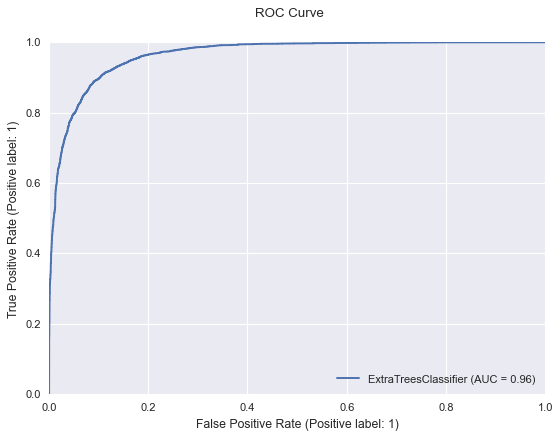

In [89]:
plt.style.use('seaborn')
disp = metrics.plot_roc_curve(Final_Model, X_test, Y_test)
disp.figure_.suptitle("ROC Curve")
plt.show()

I have generated the ROC Curve for my final model and it shows the AUC score for my final model to be of 96%

# Confusion Matrix

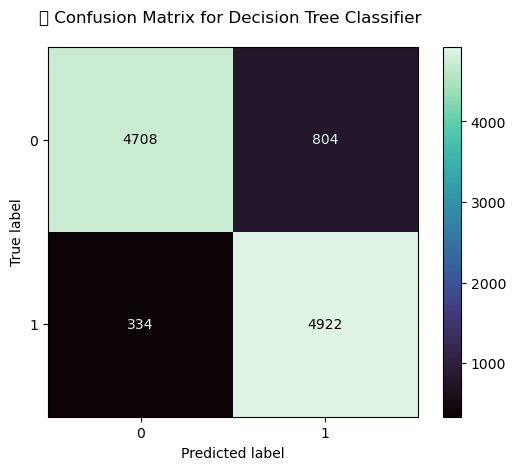

In [92]:
plt.style.use('default')
class_names = df.columns
metrics.plot_confusion_matrix(Classifier, X_test, Y_test, cmap='mako')
plt.title('\t Confusion Matrix for Decision Tree Classifier \n')
plt.show()

With the help of above confusion matrix I am able to understand the number of times I got the correct outputs and the number of times my ML model missed to provide the correct prediction (depicting in the black boxes).

# Saving the model

In [93]:
filename = "FinalModel_E05.pkl"
joblib.dump(Final_Model, filename)

['FinalModel_E05.pkl']

Finally I am saving my best classification model using the joblib library.